In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, Binarizer, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm_notebook
from bayes_opt import BayesianOptimization

color = sns.color_palette()
%matplotlib inline

#pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

lgbr = LGBMRegressor()

In [9]:
%%time
#May be skipped! all data can be readed from Data/train_X, test_X, train_y

# Read and preprocessing the data
train_df = pd.read_csv("Data/train.csv", parse_dates=['date1'])
test_df = pd.read_csv("Data/test.csv", parse_dates=['date1'])

# remove unused in test data columns and convert data to days from 01/01/2015
train_df = train_df.drop(['start_square', 'plan_s', 'plan_m', 'plan_l', 'vid_0', 'vid_1', 'vid_2'], axis=1)
train_df['date1_year'] = train_df['date1'].dt.year
train_df['date1_month'] = train_df['date1'].dt.month
train_df['date1'] = (train_df['date1'] - pd.Timestamp('2015-01-01')).dt.days

test_df['date1_year'] = test_df['date1'].dt.year
test_df['date1_month'] = test_df['date1'].dt.month
test_df['date1'] = (test_df['date1'] - pd.Timestamp('2015-01-01')).dt.days

# bulk_id that exist in train and in test
common_bulk_id = list(set(train_df['bulk_id'].unique()) & set(test_df['bulk_id'].unique()))
# new id for easy separate series
train_df['bulk_spalen_id'] = train_df['bulk_id'] + '_' + train_df['spalen'].map(str)
test_df['bulk_spalen_id'] = test_df['bulk_id'] + '_' + test_df['spalen'].map(str)

# getting unique values
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_features = unique_df[unique_df["unique_count"]==1]['col_name'].tolist()

# drop constant features
train_df = train_df.drop(constant_features + ['id'], axis=1)
test_df = test_df.drop(constant_features + ['id'], axis=1)

# so 'bulk_id' will be encoded as label and other features will OneHot
le_bulk = LabelEncoder()
le_bulk.fit(train_df['bulk_id'].append(test_df['bulk_id']))

# handling cat features
cat_features = train_df.columns[train_df.dtypes == 'object'].drop(['bulk_id', 'bulk_spalen_id'])

train_df = pd.get_dummies(train_df, columns=cat_features)
test_df = pd.get_dummies(test_df, columns=cat_features)

print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)

# save train and test data
#train_X.to_csv('Data/train_X.csv', index=False)
#test_X.to_csv('Data/test_X.csv', index=False)
#train_y.tofile('Data/train_y.csv', sep = ',')

Train rows and columns :  (8716, 57)
Test rows and columns :  (1770, 56)
Wall time: 232 ms


In [92]:
%%time
def FeatureCreation(data, create_date_features = False):
    ''' добавляет регрессионные признаки, определяет выходные и праздничные дни'''
    K_back = 12 # на сколько месяцев назад добавлять признаки
    Months_forward = 3
    
    df = data.copy(deep = True)
    T = len(df) + 1

    # добавляем sin и cos признаки
    #for k in range(1, K+1):
    #    df['s' + str(k)] = [np.sin(i * 2 * np.pi * k / period) for i in range(1, T)]
    #    df['c' + str(k)] = [np.cos(i * 2 * np.pi * k / period) for i in range(1, T)]
    
    # кол-во поездок в это же время k_hour часов назад
    for k_month in range (1, K_back + 1):
        df[str(k_month) + '_back'] = df.value.shift(k_month)
        df = df.fillna(df.mean())
    
    df['mean'] = df.value.mean()
    df['std'] = df.value.std()
    df['min'] = df.value.min()
    df['max'] = df.value.max()
    
    return df

# merge train and test to count previous values for 12 months
common_df = train_df.append(test_df, ignore_index=True)
bulks = np.unique(common_df.bulk_spalen_id)
ind = train_df.index

key_features = ['spalen', 'value', 'date1', 'date1_month', 'date1_year']
rez_df = []
train_length = len(train_df)

for bulk in tqdm_notebook(bulks):
    rez = common_df[(common_df.bulk_spalen_id == bulk)]
    rez_df.append(FeatureCreation(rez))
    #print(rez)
    #plt.plot(rez.date1, rez.value)
summary_df = rez_df[0].append([rez_df[i] for i in range (1,len(rez_df))])

train_X = summary_df.loc[ind].drop(['value', 'bulk_spalen_id'], axis = 1).fillna(0)
test_X = summary_df.drop(ind).drop(['value', 'bulk_spalen_id'], axis = 1).fillna(0)
#train_X = summary_df.loc[ind].drop(['value', 'bulk_id'], axis = 1).fillna(0)
#test_X = summary_df.drop(ind).drop(['value', 'bulk_id'], axis = 1).fillna(0)
train_y = summary_df.loc[ind]['value'].values

test_X.sort_index(inplace = True)

# save train and test data
train_X.to_csv('Data/train_X.csv', index=False)
test_X.to_csv('Data/test_X.csv', index=False)
train_y.tofile('Data/train_y.csv', sep = ',')

HBox(children=(IntProgress(value=0, max=941), HTML(value='')))


Wall time: 2min 54s


In [78]:
simple_model_columns = ['bulk_id', 'spalen', 'date1', 'price', 'mean_sq', 'mean_fl', 'month', 'month_cnt', 
        'Количество помещений', 'Площадь земельного участка', 'Детский сад', 'Школа', 'Поликлиника', 'ФОК', 
        'Кондиционирование', 'Вентлияция', 'Видеонаблюдение', 'Машиномест', 'Площадь пром. зоны в радиусе 500 м',
        'Площадь зеленой зоны в радиусе 500 м', 'До Кремля', 'До ТТК(км)', 'До Садового(км)', 'До большой дороги на машине(км)',
        'До удобной авторазвязки на машине(км)', 'До метро пешком(км)', 'До промки(км)', 'До парка(км)', 'До парка пешком(км)',
        'Станций метро от кольца', 'Площадь двора', 'Курс', 'Cтавка по ипотеке', 'Вклады до 1 года', 'Вклады от 1 года до 3 лет',
        'Вклады свыше 3 лет', 'Класс объекта_комфорт', 'Класс объекта_стандарт', 'Класс объекта_эконом', 
        'Огорожена территория_да', 'Огорожена территория_нет', 'Входные группы_да', 'Входные группы_нет', 'Автомойка_да', 
        'Автомойка_нет', 'Кладовые_да', 'Кладовые_нет', 'Колясочные_да', 'Колясочные_нет', 'Подземная парковка_да',
        'Подземная парковка_нет', 'Двор без машин_да', 'Двор без машин_нет']

In [79]:
train_X = pd.read_csv("Data/train_X.csv")
test_X = pd.read_csv("Data/test_X.csv")
train_y = np.fromfile('Data/train_y.csv', sep = ',')

In [93]:
train_X.head()

,Cтавка по ипотеке,bulk_id,date1,date1_month,date1_year,mean_fl,mean_sq,month,month_cnt,price,spalen,Автомойка_да,Автомойка_нет,Вентлияция,Видеонаблюдение,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет,Входные группы_да,Входные группы_нет,Двор без машин_да,Двор без машин_нет,Детский сад,До Кремля,До Садового(км),До ТТК(км),До большой дороги на машине(км),До метро пешком(км),До парка пешком(км),До парка(км),До промки(км),До удобной авторазвязки на машине(км),Кладовые_да,Кладовые_нет,Класс объекта_комфорт,Класс объекта_стандарт,Класс объекта_эконом,Количество помещений,Колясочные_да,Колясочные_нет,Кондиционирование,Курс,Машиномест,Огорожена территория_да,Огорожена территория_нет,Площадь двора,Площадь зеленой зоны в радиусе 500 м,Площадь земельного участка,Площадь пром. зоны в радиусе 500 м,Подземная парковка_да,Подземная парковка_нет,Поликлиника,Станций метро от кольца,ФОК,Школа,1_back,2_back,3_back,4_back,5_back,6_back,7_back,8_back,9_back,10_back,11_back,12_back,mean,std,min,max
0,10.04,FF3814A9-9F7D-E711-8530-00505688958B,1004,10,2017,8,38.00,10,34,135633.913043,1,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,961.775,961.775,961.775,953.566667,825.6,1124.5,0.0,0.0,0.0,0.0,0.0,0.0,961.775,215.152561,526.7,1209.5
1,10.04,FF3814A9-9F7D-E711-8530-00505688958B,1004,10,2017,9,58.01,10,34,128492.419825,2,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,1251.125,1251.125,1251.125,1222.533333,1399.0,1412.3,0.0,0.0,0.0,0.0,0.0,0.0,1251.125,181.202689,869.6,1412.3
2,10.04,FF3814A9-9F7D-E711-8530-00505688958B,1004,10,2017,10,22.58,10,34,158237.634409,0,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,195.250,195.250,195.250,211.366667,218.0,345.0,0.0,0.0,0.0,0.0,0.0,0.0,195.250,77.070282,91.0,345.0
3,10.04,FF3814A9-9F7D-E711-8530-00505688958B,1004,10,2017,8,78.81,10,34,123250.000000,3,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,571.800,571.800,571.800,557.066667,629.9,769.4,0.0,0.0,0.0,0.0,0.0,0.0,571.800,110.569375,411.4,769.4
4,9.87,FF3814A9-9F7D-E711-8530-00505688958B,1035,11,2017,9,37.93,11,35,139420.634921,1,0,1,1,0,5.17,7.07,6.20,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,58.926552,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,1124.500,961.775,961.775,953.566667,825.6,1124.5,0.0,0.0,0.0,0.0,0.0,0.0,961.775,215.152561,526.7,1209.5


In [94]:
# OneHotEncoder
le_bulk = LabelEncoder()
le_bulk.fit(train_X['bulk_id'].append(test_X['bulk_id']))
train_X['bulk_id'] = le_bulk.transform(train_X['bulk_id'])
test_X['bulk_id'] = le_bulk.transform(test_X['bulk_id'])

#train_X = train_X.drop('bulk_id', axis = 1)
#test_X = test_X.drop('bulk_id', axis = 1)

In [41]:
# OR dummy bulk_id
'''
train_X = summary_df.loc[ind].drop(['value', 'bulk_id'], axis = 1).fillna(0)
test_X = summary_df.drop(ind).drop(['value', 'bulk_id'], axis = 1).fillna(0)
train_y = summary_df.loc[ind]['value'].values

test_X.sort_index(inplace = True)

categories = np.unique(common_df.bulk_spalen_id) #np.union1d(train_X.bulk_id, test_X.bulk_id)
train_X['bulk_spalen_id'] = train_X.bulk_spalen_id.astype('category', categories=categories)
test_X['bulk_spalen_id'] = test_X.bulk_spalen_id.astype('category', categories=categories)

train_X = pd.get_dummies(train_X, columns=['bulk_spalen_id'])
test_X = pd.get_dummies(test_X, columns=['bulk_spalen_id'])
'''

C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  if __name__ == '__main__':
C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  # Remove the CWD from sys.path while we load stuff.


In [95]:
train_data = train_X #[significant_features]
test_data = test_X #[significant_features]

train_X.head()

,Cтавка по ипотеке,bulk_id,date1,date1_month,date1_year,mean_fl,mean_sq,month,month_cnt,price,spalen,Автомойка_да,Автомойка_нет,Вентлияция,Видеонаблюдение,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет,Входные группы_да,Входные группы_нет,Двор без машин_да,Двор без машин_нет,Детский сад,До Кремля,До Садового(км),До ТТК(км),До большой дороги на машине(км),До метро пешком(км),До парка пешком(км),До парка(км),До промки(км),До удобной авторазвязки на машине(км),Кладовые_да,Кладовые_нет,Класс объекта_комфорт,Класс объекта_стандарт,Класс объекта_эконом,Количество помещений,Колясочные_да,Колясочные_нет,Кондиционирование,Курс,Машиномест,Огорожена территория_да,Огорожена территория_нет,Площадь двора,Площадь зеленой зоны в радиусе 500 м,Площадь земельного участка,Площадь пром. зоны в радиусе 500 м,Подземная парковка_да,Подземная парковка_нет,Поликлиника,Станций метро от кольца,ФОК,Школа,1_back,2_back,3_back,4_back,5_back,6_back,7_back,8_back,9_back,10_back,11_back,12_back,mean,std,min,max
0,10.04,258,1004,10,2017,8,38.00,10,34,135633.913043,1,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,961.775,961.775,961.775,953.566667,825.6,1124.5,0.0,0.0,0.0,0.0,0.0,0.0,961.775,215.152561,526.7,1209.5
1,10.04,258,1004,10,2017,9,58.01,10,34,128492.419825,2,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,1251.125,1251.125,1251.125,1222.533333,1399.0,1412.3,0.0,0.0,0.0,0.0,0.0,0.0,1251.125,181.202689,869.6,1412.3
2,10.04,258,1004,10,2017,10,22.58,10,34,158237.634409,0,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,195.250,195.250,195.250,211.366667,218.0,345.0,0.0,0.0,0.0,0.0,0.0,0.0,195.250,77.070282,91.0,345.0
3,10.04,258,1004,10,2017,8,78.81,10,34,123250.000000,3,0,1,1,0,5.74,5.94,6.03,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.698052,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,571.800,571.800,571.800,557.066667,629.9,769.4,0.0,0.0,0.0,0.0,0.0,0.0,571.800,110.569375,411.4,769.4
4,9.87,258,1035,11,2017,9,37.93,11,35,139420.634921,1,0,1,1,0,5.17,7.07,6.20,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,58.926552,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,1124.500,961.775,961.775,953.566667,825.6,1124.5,0.0,0.0,0.0,0.0,0.0,0.0,961.775,215.152561,526.7,1209.5


In [82]:
missing_df = test_X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [83]:
dtype_df = train_X.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,34
1,float64,37


In [84]:
dtype_df = test_X.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,34
1,float64,37


In [85]:
print(train_X.shape)
print(test_X.shape)

(8716, 71)
(1770, 71)


In [86]:
%%time
def run_lgb(train_X, train_y, val_X, val_y, test_X, params):
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], early_stopping_rounds=200, verbose_eval=0, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result


def lgb_selection(n_estimators, num_leaves, learning_rate):
    KFold = 5
    kf = model_selection.KFold(n_splits=KFold, shuffle=True, random_state=2017)
    pred_test_full = 0
    average_score = []
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "n_estimators": int(n_estimators),
        "num_leaves" : int(num_leaves),
        "learning_rate" : learning_rate,
        "bagging_fraction" : 0.95,
        "feature_fraction" : 0.3,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

    for dev_index, val_index in kf.split(train_data):
        dev_X, val_X = train_data.iloc[dev_index,:], train_data.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_data, params)
        pred_test_full += pred_test
        average_score.append(np.min(evals_result['valid_0']['rmse']))

    pred_test_full /= float(KFold)
    score = np.mean(average_score)
    #print ('Average score:  ', score)

    # some predictions are negative, replace them by 0
    pred_test_full[pred_test_full < 0] = 0

    return -score #, pred_test_full

Wall time: 0 ns


In [96]:
lgbBO = BayesianOptimization(lgb_selection,
        {'n_estimators': (10, 40000),
        'num_leaves': (10, 300),
        'learning_rate': (0.0001, 0.1)}
    )

In [97]:
lgbBO.initialize({'target': [-400], 'n_estimators': [1000], 'num_leaves': [10], 'learning_rate': [0.02]})

In [100]:
gp_params = {'kernel': None,
             'alpha': 1e-5}

lgbBO.maximize(n_iter=5, acq='ei', **gp_params)

Bayesian Optimization
-------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   n_estimators |   num_leaves | 


C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Average score:   214.9311724142239
   17 | 01m17s | -214.93117 |          0.0410 |      4607.2933 |     171.5576 | 
Average score:   216.051574460748
   18 | 00m47s | -216.05157 |          0.0848 |      8436.2721 |     141.5190 | 
Average score:   212.2469862970353
   19 | 00m54s | -212.24699 |          0.0364 |      8135.5891 |     110.8151 | 
Average score:   212.02586745374182
   20 | 00m12s | -212.02587 |          0.0691 |      2874.1501 |      42.7621 | 
Average score:   214.94728013900445
   21 | 01m19s | -214.94728 |          0.0321 |       322.6375 |     279.0524 | 


In [101]:
lgbBO.res['max']

{'max_params': {'learning_rate': 0.07406945640675348,
  'n_estimators': 19424.437894670504,
  'num_leaves': 31.275639785534075},
 'max_val': -212.022295199878}

In [ ]:
# Making a submission file #
    sub_df = pd.DataFrame({"id":range(len(pred_test_full))})
    sub_df["value"] = pred_test_full

In [83]:
# merging 2 predictions - base and new
base_submission = pd.read_csv('base_submission.csv')
temp_df = pd.read_csv("Data/test.csv", parse_dates=['date1'])

changed = 0
for i in range (len(temp_df)):
    if temp_df.iloc[i]['bulk_id'] in common_bulk_id:
        pass
    else:
        changed += 1
        #print (i, '  ', sub_df.iloc[i].value, '   ', base_submission.iloc[i].value)
        sub_df.loc[i, 'value'] = base_submission.iloc[i].value
sub_df.to_csv('regression (score ' + str(round(score, 4)) + ').csv', index=False)

12    379.0     349.79785263951965
13    23.109040821027378     272.35555739895767
14    7.755292342120674     46.543213826057574
15    22.00210856392086     237.62301216270023
64    21.255332529522153     1118.319642246496
65    9.621284344274944     289.71792541506267
66    0.45691256829341287     120.18063500202295
67    18.509072226917738     410.05048773136923
68    14.560325049281271     221.67889820440482
69    87.57804819597428     1101.7694397550554
70    87.93012117433213     398.94285255265737
71    77.57187558150022     335.45825677324785
72    69.2495275250228     107.11484460477192
97    21.33374263658557     1126.4637008592185
98    12.70198371817049     289.1201744069132
99    8.400279367837737     117.85796727762035
100    18.95979785500318     439.22256189602587
101    15.436145985986451     180.8316642093608
102    87.65460489631847     1169.0660686748427
103    77.40304796379174     328.73970148286634
104    84.5642618847377     416.6598155013368
105    65.512333944

In [85]:
test_X.head()

,Cтавка по ипотеке,bulk_id,date1,date1_month,date1_year,mean_fl,mean_sq,month,month_cnt,price,spalen,Автомойка_да,Автомойка_нет,Вентлияция,Видеонаблюдение,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет,Входные группы_да,Входные группы_нет,Двор без машин_да,Двор без машин_нет,Детский сад,До Кремля,До Садового(км),До ТТК(км),До большой дороги на машине(км),До метро пешком(км),До парка пешком(км),До парка(км),До промки(км),До удобной авторазвязки на машине(км),Кладовые_да,Кладовые_нет,Класс объекта_комфорт,Класс объекта_стандарт,Класс объекта_эконом,Количество помещений,Колясочные_да,Колясочные_нет,Кондиционирование,Курс,Машиномест,Огорожена территория_да,Огорожена территория_нет,Площадь двора,Площадь зеленой зоны в радиусе 500 м,Площадь земельного участка,Площадь пром. зоны в радиусе 500 м,Подземная парковка_да,Подземная парковка_нет,Поликлиника,Станций метро от кольца,ФОК,Школа,1_back,2_back,3_back,4_back,5_back,6_back,7_back,8_back,9_back,10_back,11_back,12_back,mean,std,min,max
8716,9.78,258,1127,2,2018,9,37.97,2,38,144734.016393,1,0,1,1,0,5.48,6.20,6.16,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,56.806705,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,986.400,1209.5,526.7,1124.5,825.6,1124.5,0.0,0.0,0.0,0.0,0.0,0.0,961.775,215.152561,526.7,1209.5
8717,9.78,258,1127,2,2018,9,57.78,2,38,136729.844961,2,0,1,1,0,5.48,6.20,6.16,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,56.806705,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,1336.900,869.6,1385.7,1412.3,1399.0,1412.3,0.0,0.0,0.0,0.0,0.0,0.0,1251.125,181.202689,869.6,1412.3
8718,9.78,258,1127,2,2018,10,23.21,2,38,167787.719298,0,0,1,1,0,5.48,6.20,6.16,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,56.806705,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,146.900,198.1,91.0,345.0,218.0,345.0,0.0,0.0,0.0,0.0,0.0,0.0,195.250,77.070282,91.0,345.0
8719,9.78,258,1127,2,2018,9,79.39,2,38,132855.319149,3,0,1,1,0,5.48,6.20,6.16,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,56.806705,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,616.000,411.4,490.4,769.4,629.9,769.4,0.0,0.0,0.0,0.0,0.0,0.0,571.800,110.569375,411.4,769.4
8720,9.70,258,1155,3,2018,9,37.99,3,39,147387.111111,1,0,1,1,0,5.53,6.13,5.63,1,0,1,0,345,18.0,16.0,12.0,0.55,1.4,0.93,0.58,0.28,1.7,1,0,0,0,1,1983,1,0,1,57.063605,1800,0,1,7640.0,25533.0,17.0,65357.0,1,0,0,8.0,0,825,961.775,986.4,1209.5,526.7,1124.5,1124.5,0.0,0.0,0.0,0.0,0.0,0.0,961.775,215.152561,526.7,1209.5


In [79]:
test_X[test_X.bulk_spalen_id == 623][['bulk_spalen_id', 'date1_month', 'date1_year', '1_back', '2_back', 'mean']]

,bulk_spalen_id,date1_month,date1_year,1_back,2_back,mean
10139,623,3,2018,48.02,24.12,144.731


In [81]:
summary_df[summary_df.bulk_spalen_id == 623][['bulk_spalen_id', 'date1_month', 'date1_year', '1_back', '2_back', 'mean']].tail(20)

,bulk_spalen_id,date1_month,date1_year,1_back,2_back,mean


In [17]:
significant_features = ['date1', 'price', 'mean_sq', 'mean_fl', 'month', 
        'Количество помещений', 'Площадь земельного участка', 'Детский сад', 'Школа',  
        'Кондиционирование', 'Машиномест', 'Площадь пром. зоны в радиусе 500 м',
        'Площадь зеленой зоны в радиусе 500 м', 'До Кремля', 'До большой дороги на машине(км)',
        'До удобной авторазвязки на машине(км)', 'До метро пешком(км)', 'До промки(км)', 'До парка(км)', 'До парка пешком(км)',
        'Площадь двора', 'Курс', 'Cтавка по ипотеке', 'Вклады до 1 года', 'Вклады от 1 года до 3 лет',
        'Вклады свыше 3 лет']

NameError: name 'model' is not defined

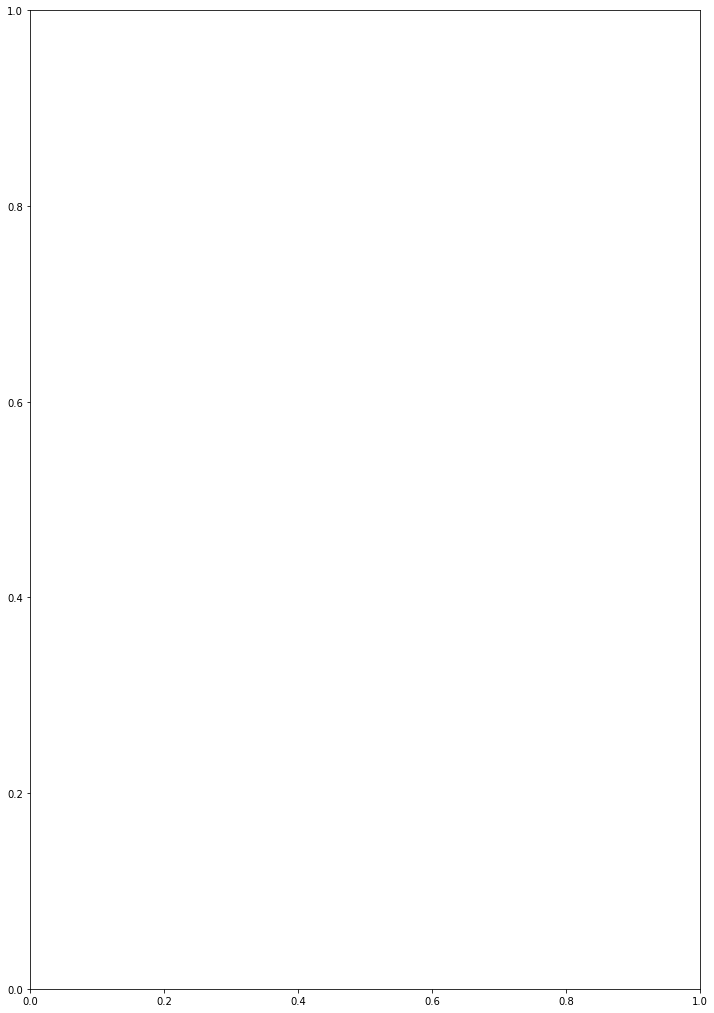

In [102]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=-1, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()